{'attr_dict': {'longitude': -76.712009, 'latitude': 39.2536219}}
# of edges: 190
# of nodes: 20


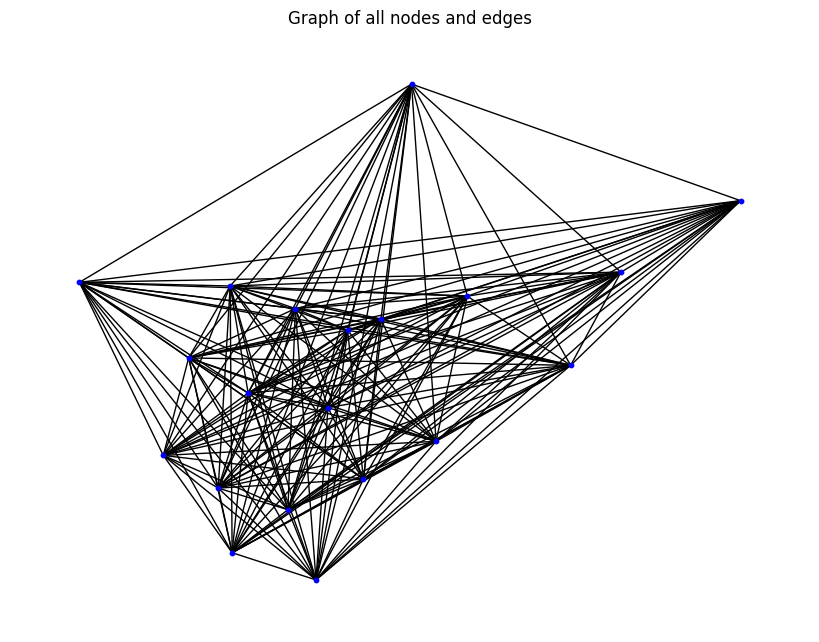

# of nodes with odd degree: 20
# of total nodes: 20
# of odd node pairs: 190


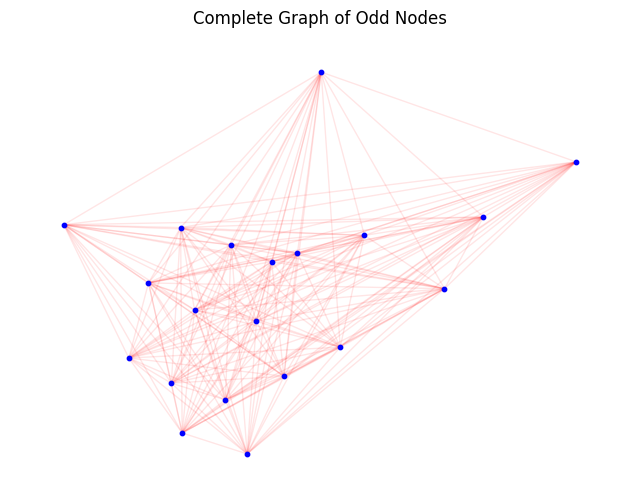

# of edges in matching: 10
# of edges in matching (deduped): 10


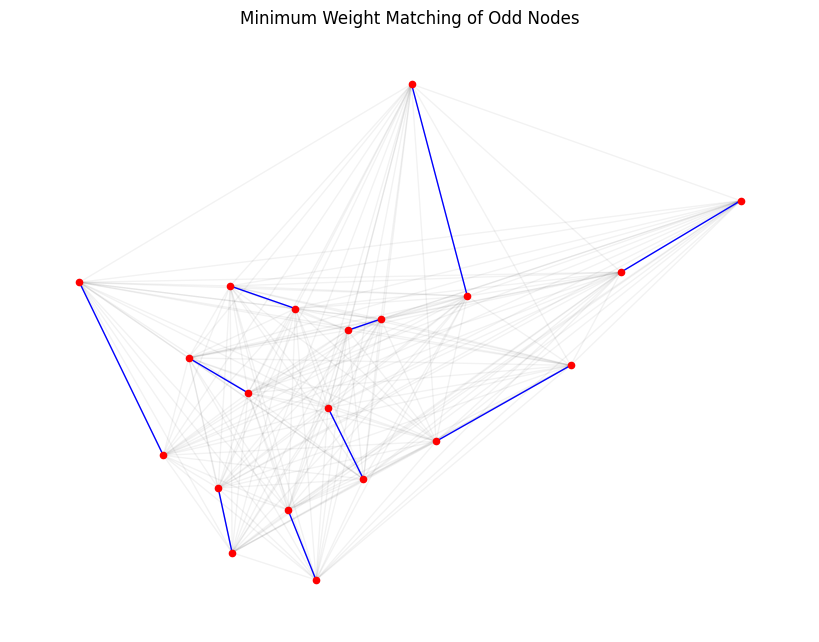

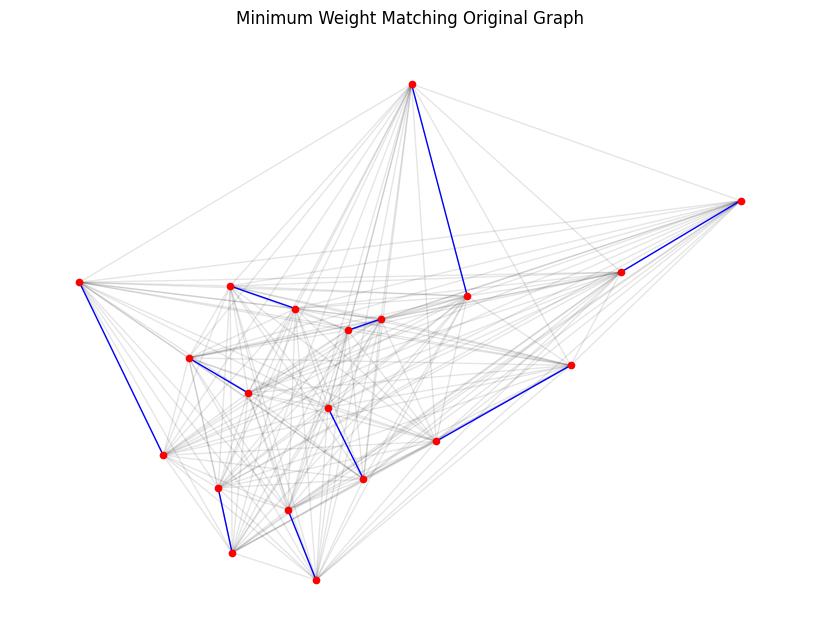

# of edges in original graph: 190
# of edges in augmented graph: 200
# of edges in eulerian circuit: 200
# of edges in cpp edgelist: 190


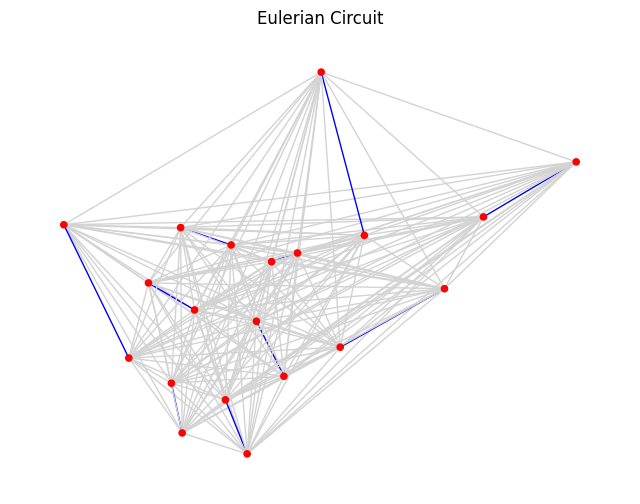

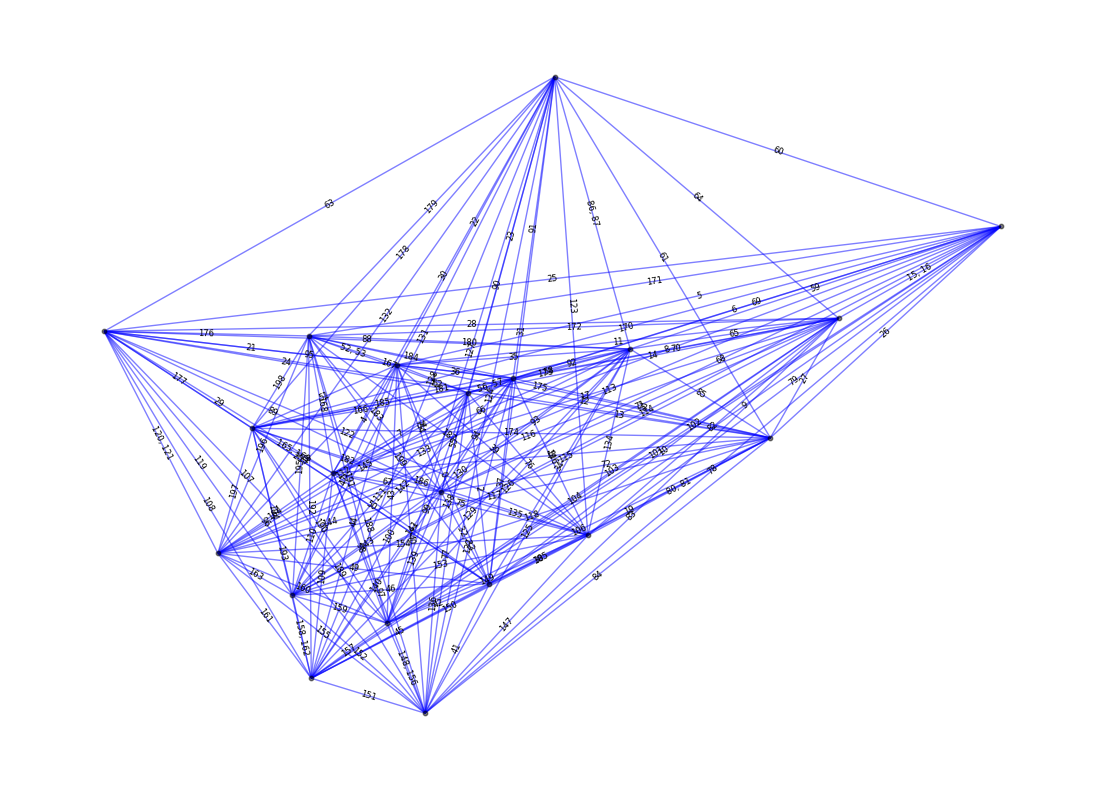

# of edges in minimum spanning tree: 19


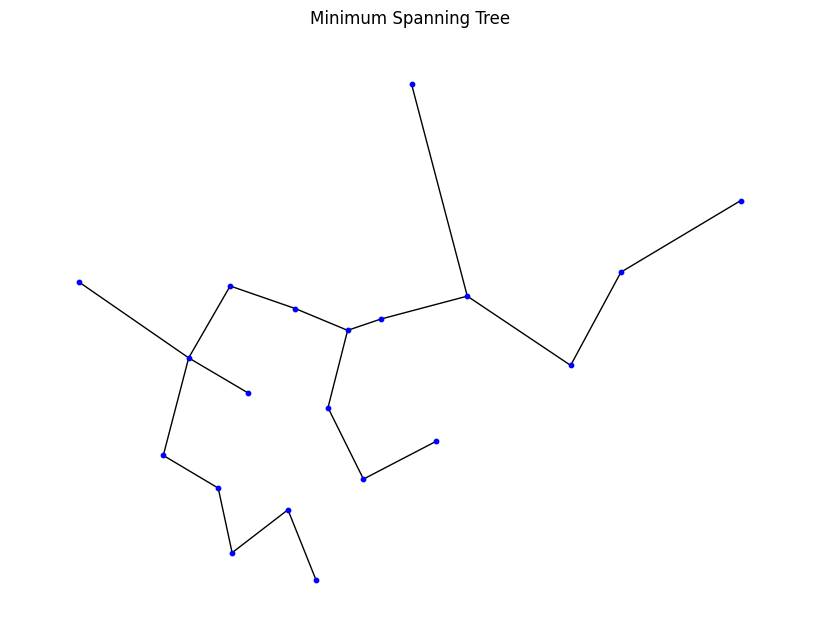

In [3]:
"""keeps only necessary edges in a graph"""

import argparse
import itertools
import copy
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

EDGE_FILE = "umbcPOIEdges.csv"
NODE_FILE = "UMBCPOI.csv"

def meaningful_edge(edges):
    '''if the distance is out side of 1/2 standard deviation of the mean, remove the edge from the edges list'''
    df = pd.DataFrame(edges)
    df.columns = ['from', 'to', 'distance']
    df['distance'] = df['distance'].astype(float)
    mean = df['distance'].mean()
    std = df['distance'].std()
    df = df[(df['distance'] > mean - std/2) & (df['distance'] < mean + std/2)]
    return df

def get_shortest_paths_distances(g, pairs, edge_weight_name):
    distances = {}
    for pair in pairs:
        distances[pair] = nx.shortest_path_length(g, pair[0], pair[1], weight=edge_weight_name)
    return distances

def create_complete_graph(pair_weights, flip_weights=True):
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = -v if flip_weights else v
        g.add_edge(k[0], k[1], weight=wt_i)
    return g

def add_augmenting_path_to_graph(g, min_pairs):
    graph_aug = nx.MultiGraph(g.copy())
    for pair in min_pairs:
        graph_aug.add_edge(pair[0], pair[1], weight=nx.shortest_path_length(g, pair[0], pair[1]), trail="augmented")
    return graph_aug

def create_eulerian_circuit(g_aug, g_full, start_node=None):
    euler_circuit = []
    naive_circuit = list(nx.eulerian_circuit(g_aug, source=start_node))

    for edge in naive_circuit:
        edge_data=g_aug.get_edge_data(edge[0], edge[1])

        if 'trail' in edge_data[0].keys():
            if edge_data[0]['trail'] != 'augmented':
                edge_att = g_full[edge[0]][edge[1]]
                euler_circuit.append((edge[0], edge[1], edge_att))
        else:
            aug_path = nx.shortest_path(g_full, edge[0], edge[1], weight="weight")
            aug_path_pairs = list(zip(aug_path[:-1], aug_path[1:]))

            # print('Filling in edges for augmented edge: {}'.format(edge))
            # print('Augmenting path: {}'.format(' => '.join(aug_path)))
            # print('Augmenting path pairs: {}\n'.format(aug_path_pairs))

            for edge_aug in aug_path_pairs:
                edge_aug_att = g_full[edge_aug[0]][edge_aug[1]]
                euler_circuit.append((edge_aug[0], edge_aug[1], edge_aug_att))

    return euler_circuit


def create_cpp_edgelist(euler_circuit):
    cpp_edgelist = {}

    for i, e in enumerate(euler_circuit):
        edge = frozenset([e[0], e[1]])
        if edge in cpp_edgelist:
            cpp_edgelist[edge][2]['sequence'] +=', '+str(i)
            cpp_edgelist[edge][2]['visits'] += 1
        else:
            cpp_edgelist[edge] = e
            cpp_edgelist[edge][2]['sequence'] = str(i)
            cpp_edgelist[edge][2]['visits'] = 1
    return list(cpp_edgelist.values())

def main():
    # parser = argparse.ArgumentParser()
    # parser.add_argument('--edges', required=True, type=str)
    # parser.add_argument('--nodes', required=True, type=str)

    # args = parser.parse_args()

    # read in the edges
    edgelist = pd.read_csv(EDGE_FILE)

    nodelist = pd.read_csv(NODE_FILE)
    # Grab edge list data hosted on Gist
    g=nx.Graph()
    for i, elrow in edgelist.iterrows():
        if elrow[0] != "node1":
            g.add_edge(elrow[0], elrow[1], weight = elrow[2])
        
    for i, nlrow in nodelist.iterrows():
        if nlrow[0] != "name":
            # g.nodes[nlrow["name"]] = nlrow[1:].to_dict()
            g.add_node(nlrow[0], attr_dict=nlrow[1:].to_dict())

    print(g.nodes["Pool"])

    print(f'# of edges: {g.number_of_edges()}')
    print(f'# of nodes: {g.number_of_nodes()}')

    node_positions = {}
    for node in g.nodes(data=True):
        node_positions[node[0]] = (node[1]['attr_dict']['longitude'], node[1]['attr_dict']['latitude'])
    
    
    dict(list(node_positions.items())[0:5])

    plt.figure(figsize=(8,6))
    nx.draw(g, pos=node_positions, node_size=10, node_color='b', with_labels=False)
    plt.title('Graph of all nodes and edges')
    plt.show()

    nodes_odd_degree = [v for v, d in g.degree() if d % 2 == 1]

    print(f'# of nodes with odd degree: {len(nodes_odd_degree)}')
    print(f'# of total nodes: {g.number_of_nodes()}')

    odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))
    print(f'# of odd node pairs: {len(odd_node_pairs)}')

    odd_node_pairs_shortest_paths = get_shortest_paths_distances(g, odd_node_pairs, 'weight')
    # print(odd_node_pairs_shortest_paths)

    g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)
    
    plt.figure(figsize=(8,6))
    pos_random=nx.random_layout(g_odd_complete)
    nx.draw_networkx_nodes(g_odd_complete, pos=node_positions, node_size=10, node_color='b')
    nx.draw_networkx_edges(g_odd_complete, pos=node_positions, edge_color='r', width=1, alpha =0.1)
    plt.axis('off')
    plt.title('Complete Graph of Odd Nodes')
    plt.show()

    odd_matching_dupes = nx.algorithms.max_weight_matching(g_odd_complete, True)
    print(f'# of edges in matching: {len(odd_matching_dupes)}')

    odd_matching = list(pd.unique([tuple(sorted([k,v])) for k, v in odd_matching_dupes]))
    print(f'# of edges in matching (deduped): {len(odd_matching)}')

    plt.figure(figsize=(8,6))
    nx.draw(g_odd_complete, pos = node_positions, node_size=20, alpha=.05)
    g_odd_complete_min_edges = nx.Graph(odd_matching)
    nx.draw(g_odd_complete_min_edges, pos = node_positions, node_size=20, edge_color='b',node_color='r')
    plt.title('Minimum Weight Matching of Odd Nodes')
    plt.show()

    plt.figure(figsize=(8,6))
    nx.draw(g,pos=node_positions, node_size=20, alpha=.1, node_color='black')
    nx.draw(g_odd_complete_min_edges, pos = node_positions, node_size=20, edge_color='b',node_color='r', alpha=1)
    plt.title('Minimum Weight Matching Original Graph')
    plt.show()

    g_aug = add_augmenting_path_to_graph(g, odd_matching)
    print(f'# of edges in original graph: {g.number_of_edges()}')
    print(f'# of edges in augmented graph: {g_aug.number_of_edges()}')

    euler_circuit = create_eulerian_circuit(g_aug, g, start_node="Pool")
    print(f'# of edges in eulerian circuit: {len(euler_circuit)}')

    # for i, edge in enumerate(euler_circuit):
        # print(f'Edge {i}: {edge}')
        

    cpp_edgelist = create_cpp_edgelist(euler_circuit)
    print(f'# of edges in cpp edgelist: {len(cpp_edgelist)}')
    # print(cpp_edgelist[0:5])

    g_cpp = nx.Graph(cpp_edgelist)

    plt.figure(figsize=(8,6))
    visit_colors = {1:'lightgray', 2:'b'}
    edge_colors = [visit_colors[e[2]['visits']] for e in g_cpp.edges(data=True)]
    node_colors = ['red'  if node in nodes_odd_degree else 'lightgray' for node in g_cpp.nodes()]
    nx.draw_networkx(g_cpp, pos=node_positions, node_size=20, node_color=node_colors, edge_color=edge_colors, with_labels=False)
    plt.title('Eulerian Circuit')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(14, 10))

    edge_colors = 'b'
    nx.draw_networkx(g_cpp, pos=node_positions, node_size=10, node_color='black', edge_color=edge_colors, with_labels=False, alpha=0.5)

    bbox = {'ec':[1,1,1,0], 'fc':[1,1,1,0]}  # hack to label edges over line (rather than breaking up line)
    edge_labels = nx.get_edge_attributes(g_cpp, 'sequence')
    nx.draw_networkx_edge_labels(g_cpp, pos=node_positions, edge_labels=edge_labels, bbox=bbox, font_size=6)

    plt.axis('off')
    plt.show()

    min_graph = nx.minimum_spanning_tree(g)
    print(f'# of edges in minimum spanning tree: {min_graph.number_of_edges()}')

    plt.figure(figsize=(8,6))
    nx.draw(min_graph, pos=node_positions, node_size=10, node_color='b', with_labels=False)
    plt.title('Minimum Spanning Tree')
    plt.show()
    

if __name__ == '__main__':
    main()
